At the University of Maryland, students often refer to course creating services such as [courseoff](https://umd.courseoff.com/) or [venus](https://venus.umd.edu/). These services take data from the class repository called [testudo](https://www.testudo.umd.edu) and allows students to create interactive schedules with all information (professor, time, section, etc.) in one convenient location. These services are paired with a UMD based review site known as [planetterp](planetterp.com). Unlike the aforementioned schedule builders, planetterp does not offer a scheduling system: instead, it is a search engine for course grade data, reviews, and professor information. The data is most regularly used to find the 'best' professors teaching a desired course during a term. <br> <br>
Let's take a look at the data for the course CMSC320 - Introduction to Data Science:


>Average GPA: 3.30 of <br>
>Fall 2022 Professors: [Maksym Morawsky, Elias Gonzales] <br>
>Prerequisites: Minimum C- in CMSC216 and CMSC250 <br>



Objectives:
1. Query CMSC course data
2. Clean and combine 
3. Explore dataset
   1. GPA vs. rating?
   2. Rating trends?
   3. Top professors?
   4. Course, professor, rankings
4. Relationship between rating and GPA
5. NLP analysis of reviews

Questions:
1. What deems a course to be good?
2. Which professors are the best for each course?
3. What kind of sentiments are present for highly rated professors

### Imports

In [46]:
import planetterp as pt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [47]:
COURSE_REIVEW_COLUMNS = ["professor", "course", "review", "rating", "expected_grade", "created"]
GRADE_WEIGHTS = [4, 4, 3.7, 3.3, 3.0, 2.7, 2.3, 2.0, 1.7, 1.3, 1.0, 0.7, 0.0]
GRADE_LETTERS = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-", "F"]
GRADE_LANDW = {"A+" : 4, "A" : 4, "A-" : 3.7, "B+" : 3.3, "B" : 3.0, "B-" : 2.7, "C+" : 2.3, "C" : 2.0, "C-" : 1.7, "D+" : 1.3, "D" : 1.0, "D-" : 0.7, "F" : 0.0}

## **Data** 

### **Retrieve course data**


In order to analyze the course information, we will use the [planetterp api](https://planetterp.com/api/). The planetterp API has the courses() function that allows us to retrieve course data from a specified department along with online reviews. Data is returned inside a dictionary with the following information:

1. Average GPA (float)
2. Professors (list)
3. Reviews (dict)
4. Department (str)
5. Course Number (str)
6. Title (str)
7. Credits (float)
8. Description (str)
9. Is_recent (bool)

We will be using the pandas API to make sense of this data. We can do this directly by converting the dictionary returned by the courses function, then converting it to a dataframe. We will specify the courses command to extract CMSC courses and to include reviews in the query.

In [48]:
courses = pd.DataFrame(pt.courses(department="CMSC", reviews=True))

In [49]:
courses

,average_gpa,professors,reviews,department,course_number,name,title,credits,description,is_recent
0,3.199664,"[Atif Memon, Adam Porter, Charles Song, Vibha ...","[{'professor': 'Adam Porter', 'course': 'CMSC4...",CMSC,436,CMSC436,Programming Handheld Systems,3.0,<b>Prerequisite:</b> Minimum grade of C- in CM...,True
1,2.672616,"[Amol Deshpande, Nicholas Roussopoulos, Peter ...","[{'professor': 'Amol Deshpande', 'course': 'CM...",CMSC,424,CMSC424,Database Design,3.0,<b>Prerequisite:</b> Minimum grade of C- in CM...,True
2,3.461364,"[Charles Kassir, Amy Vaillancourt, Alyssa Neun...","[{'professor': 'Corie Brown', 'course': 'CMSC1...",CMSC,100,CMSC100,Bits and Bytes of Computer and Information Sci...,1.0,<b>Restriction:</b> For first time freshmen an...,True
3,3.283036,"[Jonathan Katz, Andrew Childs]",[],CMSC,858K,CMSC858K,Advanced Topics in Theory of Computing; Introd...,3.0,None,True
4,2.449417,"[Alan Sussman, Larry Herman, Neil Spring, Nels...","[{'professor': 'Nelson Padua-Perez', 'course':...",CMSC,216,CMSC216,Introduction to Computer Systems,4.0,<b>Prerequisite:</b> Minimum grade of C- in CM...,True
...,...,...,...,...,...,...,...,...,...,...
95,3.407500,"[Larry Davis, Ian Miers]",[],CMSC,498I,CMSC498I,Selected Topics in Computer Science; Computer ...,3.0,Or must be in the (Computer Science (Doctoral)...,True
96,NaN,"[Peter Druschel, Samrat Bhattacharjee, Michael...",[],CMSC,818Y,CMSC818Y,Advanced Topics in Computer Systems; Fault Tol...,3.0,None,True
97,3.576923,"[Andrew Childs, Xiaodi Wu, Alexander Barg, Vic...",[],CMSC,858Q,CMSC858Q,Advanced Topics in Theory of Computing,1.0,"<i>\n<b>Prerequisite:</b> CMSC657, CMSC457 or ...",True
98,3.070455,"[Aravind Srinivasan, Aravind Srinivasan]",[],CMSC,858C,CMSC858C,Advanced Topics in Theory of Computing; Random...,3.0,None,True


Since we want to focus on undergraduate courses, we will exclude any course with any code larger than 500. We perform this by filtering the dataframe with a boolean condition on the course_number column. We also want to ensure that all professors present in the column are unique as to avoid redundancy (the api is not perfect).

In [50]:
# Take only undergrad courses
courses = courses[courses["course_number"] < "500"]
# Remove duplicate professors for courses
courses["professors"] = courses["professors"].apply(lambda x: np.unique(x))

<ipython-input-50-be8403c6d434>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  courses["professors"] = courses["professors"].apply(lambda x: np.unique(x))


In [51]:
courses

,average_gpa,professors,reviews,department,course_number,name,title,credits,description,is_recent
0,3.199664,"[Adam Porter, Atif Memon, Charles Song, Herve ...","[{'professor': 'Adam Porter', 'course': 'CMSC4...",CMSC,436,CMSC436,Programming Handheld Systems,3.0,<b>Prerequisite:</b> Minimum grade of C- in CM...,True
1,2.672616,"[Amol Deshpande, Daniel Abadi, Mihai Pop, Nich...","[{'professor': 'Amol Deshpande', 'course': 'CM...",CMSC,424,CMSC424,Database Design,3.0,<b>Prerequisite:</b> Minimum grade of C- in CM...,True
2,3.461364,"[Alyssa Neuner, Amy Vaillancourt, Andrew Nolan...","[{'professor': 'Corie Brown', 'course': 'CMSC1...",CMSC,100,CMSC100,Bits and Bytes of Computer and Information Sci...,1.0,<b>Restriction:</b> For first time freshmen an...,True
4,2.449417,"[A.U. Shankar, Alan Sussman, Anwar Mamat, Herv...","[{'professor': 'Nelson Padua-Perez', 'course':...",CMSC,216,CMSC216,Introduction to Computer Systems,4.0,<b>Prerequisite:</b> Minimum grade of C- in CM...,True
5,2.746843,"[Anwar Mamat, Chau-Wen Tseng, Cliff Bakalian, ...","[{'professor': 'Jeffrey Foster', 'course': 'CM...",CMSC,330,CMSC330,Organization of Programming Languages,3.0,<b>Prerequisite:</b> Minimum grade of C- in CM...,True
7,2.380112,"[Ashok Agrawala, Colin Dixon, Ibrahim Korpeogl...","[{'professor': 'Ashok Agrawala', 'course': 'CM...",CMSC,417,CMSC417,Computer Networks,3.0,<b>Prerequisite:</b> Minimum grade of C- in CM...,True
8,3.152688,[Ben Bederson],[],CMSC,198C,CMSC198C,None,NaN,None,True
9,2.651282,[Ben Bederson],[],CMSC,198D,CMSC198D,Special Topics in Computer Science for Non-Maj...,1.0,,True
10,0.800000,[Ben Bederson],[],CMSC,198E,CMSC198E,Special Topics in Computer Science for Non-Maj...,1.0,,True
11,2.584963,"[Aditya Acharya, Alex Liao, Alexander Brassel,...","[{'professor': 'John Aloimonos', 'course': 'CM...",CMSC,250,CMSC250,Discrete Structures,4.0,<b>Prerequisite:</b> Minimum grade of C- in CM...,True


### **Retrieve review data**

Currently, the reviews are stored in dictionaries that are difficult to parse. We can convert these into a dataframe that stores each individual review organized by the professor and course. This new dataframe will also include the review's professor rating, expected grade, and the date it was created. 

In [52]:
reviews = pd.DataFrame(columns=COURSE_REIVEW_COLUMNS)

for course in courses["reviews"]:
    reviews = pd.concat([reviews, pd.DataFrame(course)])

In [53]:
reviews

,professor,course,review,rating,expected_grade,created
0,Adam Porter,CMSC436,Easy class. Open note exams. One big group pro...,5,A-,2018-04-17T03:30:09Z
1,Adam Porter,CMSC436,Easy class but awful professor. He is frequent...,1,A,2018-11-21T01:56:02Z
2,Adam Porter,CMSC436,Totally ineffective as a lecturer. He reads fr...,1,B,2018-12-11T02:04:39Z
3,Adam Porter,CMSC436,"Porter responds to few, if any questions asked...",1,,2018-12-11T21:02:42Z
4,Adam Porter,CMSC436,436 was a fun class for me due to the subject ...,2,B,2019-12-18T16:10:39Z
...,...,...,...,...,...,...
8,William Pugh,CMSC132H,"Pugh is a really interesting professor, and re...",3,A+,2008-05-20T15:37:00Z
9,Chau-Wen Tseng,CMSC132H,"He's a little idiosyncratic, but his class is ...",4,B,2007-11-30T13:09:00Z
10,James Purtilo,CMSC132H,Purtilo is a solid professor who respects his ...,4,A+,2012-03-19T13:59:00Z
11,James Purtilo,CMSC132H,DO NOT TAKE HIM FOR CMSC132 OR ANY INTRO-LEVEL...,5,,2010-10-19T02:22:00Z


### **Retrieve grades**

To get individual course and professor grade data, we will use the grades() function. The query returns a dictionary with grade data from each section of each course instructed by a given professor. Ex:

In [54]:
pd.DataFrame(pt.grades(course="CMSC216", professor="Nelson Padua-Perez"))

,course,professor,semester,section,A+,A,A-,B+,B,B-,C+,C,C-,D+,D,D-,F,W,Other
0,CMSC216,Nelson Padua-Perez,201208,0201,1,1,3,3,3,0,4,2,4,0,1,0,1,5,0
1,CMSC216,Nelson Padua-Perez,201208,0202,0,3,0,3,2,3,6,3,2,0,1,1,1,4,0
2,CMSC216,Nelson Padua-Perez,201208,0203,0,1,2,5,2,0,4,1,2,1,2,0,2,7,1
3,CMSC216,Nelson Padua-Perez,201208,0301,0,1,3,1,6,1,7,3,1,0,1,0,0,3,0
4,CMSC216,Nelson Padua-Perez,201208,0302,0,1,2,4,2,4,2,2,2,2,0,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,CMSC216,Nelson Padua-Perez,201901,0304,3,5,4,9,4,4,2,1,0,0,0,0,1,1,2
81,CMSC216,Nelson Padua-Perez,201901,0305,5,4,5,7,3,2,2,1,1,0,0,0,1,0,4
82,CMSC216,Nelson Padua-Perez,201901,0306,3,4,6,4,3,3,2,2,1,0,0,0,1,0,7
83,CMSC216,Nelson Padua-Perez,201901,0307,2,6,3,5,3,3,3,1,0,0,2,0,4,1,2


From this format, we can retrieve the grade data for a course when givin a specific professor. Using the pandas apply() function, we will iterate through each row to compute the average GPA for the course. We will use [UMD grade weighting](https://www.testudo.umd.edu/gpa/index.html) to convert string grades into numeric values. 'W' (waived) grades will be excluded. The average is then computed than appended to the new "grades" dataframe.

In [55]:
def get_grades(course: str, professor: str):
    grades = pd.DataFrame(pt.grades(course=course, professor=professor))
   
    if grades.empty: return -1
   
    students = 0
    gpa = []
    
    for letter in GRADE_LANDW.keys():
        no_students = np.sum(grades[letter])
        students += no_students
        gpa.append(no_students * GRADE_LANDW[letter])
    
    if students == 0:
        return -1
    
    return np.mean(np.sum(gpa) / students)

grades = pd.DataFrame(columns=["course", "professor", "average_gpa"])
for index, course in courses.iterrows():
    for professor in course["professors"]:
        print(professor, course["name"])
        grade_data = pd.DataFrame([[course["name"], professor, get_grades(course["name"], professor)]], columns=["course", "professor", "average_gpa"])
        grades = pd.concat([grade_data, grades]).reset_index(drop=True)

In [56]:
grades = pd.read_csv("data/grades.csv")
grades.drop("Unnamed: 0", axis=1, inplace=True)

In [57]:
grades.head()

,course,professor,average_gpa
0,CMSC498Z,Ming Lin,3.847619
1,CMSC498Z,Ashok Agrawala,-1.000000
2,CMSC498I,Larry Davis,3.407500
3,CMSC498I,Ian Miers,-1.000000
4,CMSC498Y,Erin Molloy,3.500000


### **Clean and combine** 

We not want to combine all the data we have gathered in to one "master" dataframe. This will organize course data into professor and course pairs. For instance, a professor might teach CMSC131, CMSC132, and CMSC216. Each of their courses will occupy a row in the new dataframe, which will also include their average GPA, reviews, number of reviews, and planetterp rating (of 5 stars).  

We will start with the grades data, which is already organized based on professor-course pairings. To get the reviews for a given professor, we will parse the reviews dataframe constructed earlier, to create a dataframe object to assign to a professor-course pair. The function accounts for pairings without reviews, and will return a nan-value accordingly.

In [58]:
cdf = grades.copy()

def get_reviews(row):
    course_reviews = reviews.loc[(reviews["professor"]==row["professor"]) & (reviews["course"]==row["course"]), :]
    if course_reviews.empty:
        return np.nan
    else:
        return course_reviews

cdf["course_reviews"] = cdf.apply(get_reviews, axis=1)

Retrieving the number of reviews is a matter counting how many reviews are in the associated dataframe. If its empty, we will fill the number of reviews to 0.

In [59]:
def get_no_reviews(row):
    if row["course_reviews"] is not np.nan:
        return len(row["course_reviews"].index)
    else: 
        return -1

cdf["no_reviews"] = cdf.apply(get_no_reviews, axis=1)

Finally, to get the planetterp ratings, we will look at the reviews. Each review has a rating that is stored in a numeric value. To get the overall rating, we will take the rating within each review and take the average across all reviews. 

In [60]:
def get_course_rating(row):
    if row["course_reviews"] is not np.nan:
        return np.sum(row["course_reviews"]["rating"]) / row["no_reviews"]
    else: 
        return -1

cdf["rating"] = cdf.apply(get_course_rating, axis=1)

Now, we have a clean dataframe from which we can perform data analysis.

In [61]:
cdf

,course,professor,average_gpa,course_reviews,no_reviews,rating
0,CMSC498Z,Ming Lin,3.847619,NaN,-1,-1.0
1,CMSC498Z,Ashok Agrawala,-1.000000,NaN,-1,-1.0
2,CMSC498I,Larry Davis,3.407500,NaN,-1,-1.0
3,CMSC498I,Ian Miers,-1.000000,NaN,-1,-1.0
4,CMSC498Y,Erin Molloy,3.500000,NaN,-1,-1.0
...,...,...,...,...,...,...
346,CMSC436,Michael Marsh,3.473148,professor course ...,2,4.0
347,CMSC436,Herve Franceschi,-1.000000,NaN,-1,-1.0
348,CMSC436,Charles Song,3.111950,NaN,-1,-1.0
349,CMSC436,Atif Memon,3.460902,NaN,-1,-1.0


## **Data Analysis**

### **Rating Vs GPA**

Lets start by looking at the relationship between grades and courses: how might the average GPA for a course impact the rating the professor-course pair gets? <br>
We can explore this relationship using a scatter plot. We will be using the [matplotlib](https://matplotlib.org) library, from which we can easily create a plot. The function can specify the columns which we would like to plot, along with some visual parameters we can adjust such as plot title, axis labels, and point alpha values. 


Text(0.5, 1.0, 'GPA vs. Rating')

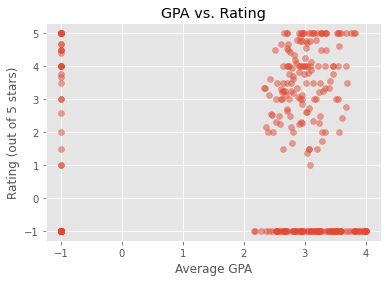

In [62]:
plt.scatter(
    cdf["average_gpa"], 
    cdf["rating"], 
    alpha=0.5)

plt.xlabel("Average GPA")
plt.ylabel("Rating (out of 5 stars)") 
plt.title("GPA vs. Rating")

We observe that there are numerous course and professor matchings that either have no GPA data or no ratings. This often occurs with courses that, compared to core courses such as CMSC216 or CMSC250, have lower student volume. There will thus be less students who could add ratings and reviews. To account for this, we can filter the dataframe based on professor-course to ones that have both ratings and gpa data. This will hopefully give us a better interpretation of the data. 

We will also be using a regression line to better understand the relationship between the two columns. Using the np.polyfit() command, we can retrieve a Least-Squares polynomial model then plot the line on the graph. We can plot the line on top of the modified data to create a concise visualization. 

In [63]:
cdf = cdf.loc[(cdf["average_gpa"] != -1) & (cdf["rating"] > -1), :]

Text(0, 0.5, 'Rating')

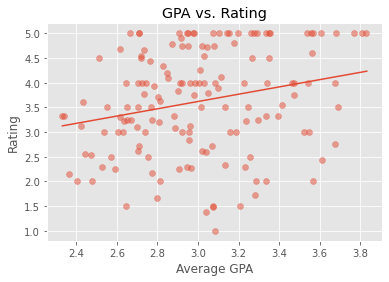

In [64]:
m, b = np.polyfit(cdf["average_gpa"], cdf["rating"], 1)

fig, ax = plt.subplots()

ax.scatter(cdf["average_gpa"], cdf["rating"], alpha=0.5)
ax.plot(
    np.arange(cdf["average_gpa"].min(), 4, .5), 
    m*np.arange(cdf["average_gpa"].min(), 4, .5)+b
    )
ax.set_title("GPA vs. Rating")
ax.set_xlabel("Average GPA")
ax.set_ylabel("Rating")

The trend line shows a positive correlation between the average GPA of a given professor-course pairing and their respective rating on planetterp. 

Now that we have examined the relationship between GPA and ratings across professor-course pairs, we can now look at how professors are rated across their courses. Using the groupby() function, we can get a new dataframe that gets the mean rating and GPA across all courses for a professor. We will drop the no_reviews column since we are not currently interested in the average number of reviews per course.

In [65]:
grouped_by_prof = cdf.groupby("professor").mean()
grouped_by_prof.drop(["no_reviews"], axis=1,inplace=True)

We will perform a similar operation for the previous plot and include a regression line

Text(0, 0.5, 'Rating')

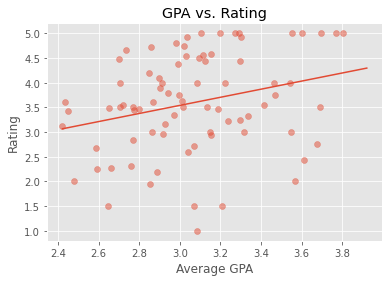

In [66]:
m2, b2 = np.polyfit(grouped_by_prof["average_gpa"], grouped_by_prof["rating"], 1)

fig, ax = plt.subplots()

ax.scatter(grouped_by_prof["average_gpa"], grouped_by_prof["rating"], alpha=0.5)
ax.plot(
    np.arange(grouped_by_prof["average_gpa"].min(), 4, .5), 
    m2*np.arange(grouped_by_prof["average_gpa"].min(), 4, .5)+b2
    )
ax.set_title("GPA vs. Rating")
ax.set_xlabel("Average GPA")
ax.set_ylabel("Rating")

In [67]:
print(m, m2)

0.7374566541805296 0.8187480098141446


Compared to the original, non-grouped data, the regression shows a more positive relationship between grades and the professor rating when considering average across classes. 

### **Review types and amounts**

Let's return to the original dataframe with all the professor-course pairings and examine how rating categories differ. Allow us to also assume that highly rated pairs are any with 3 stars or above, average pairs have a rating between 2 and 3 stars, and lowly rated pairs are considered 2 stars or below. 

In [68]:
high = cdf.loc[cdf["rating"] > 3]
avg = cdf.loc[(cdf["rating"] <= 3) & (cdf["rating"] >= 2)]
low = cdf.loc[cdf["rating"] < 2]


Using a bargrph, we can examine the difference in volume between the different strata of pairings. 

Text(0, 0.5, 'number of reviews')

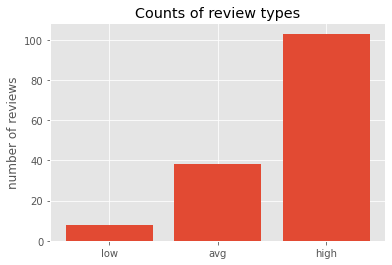

In [69]:
plt.bar(x=["low", "avg", "high"], height=[len(low), len(avg), len(high)])
plt.title("Counts of review types")
plt.ylabel("number of reviews")

As indicated by the plot, there are much more high reviews compared to low and average ratings. However, this plot is limited since it only tells us the amount of ratings, rather than other information such as frequency of specific values within each category or the average. This is where a violin plot comes in, allowing us to visualize the distribution and average for each strata. Below is a demonstration on how to show a violin plot.

Text(0.5, 1.0, 'Rating Distributions')

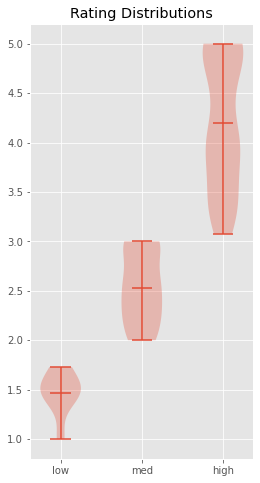

In [70]:
fig, ax = plt.subplots(figsize=(4, 8))

ax.violinplot([low["rating"], avg["rating"], high["rating"]], [1, 2 ,3], widths=0.5, showmeans=True)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['low', 'med', 'high'])
ax.set_title("Rating Distributions")

Beyond the types of reviews, we can also look at more basic information such as the number of reviews each professor will get. Since professors who teach lower level courses are more popular among undergraduates, we can expect to see some professors with much higher review counts. We will examine this through a histogram counting binning the professor-course pairs by the number of reviews they have. Below demonstrates how we can do this using the hist() function of matplotlib, which bins the data in 10 different categories then counts the amount of instances within that category. 

Text(0, 0.5, 'Number of Pairs')

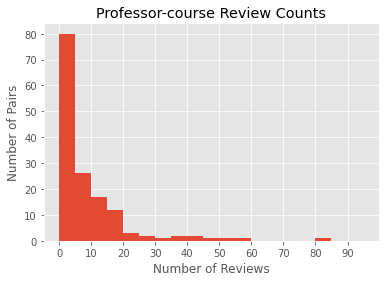

In [71]:
plt.hist(cdf["no_reviews"], bins=range(0, 100, 5))
plt.title("Professor-course Review Counts")
plt.xticks(range(0, 100, 10))
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Pairs")

Through this plot, we observe that there is a much higher density of professor course pairing that only have a couple of reviews and a few courses with more than 50 reviews. This indicates an imbalance in course reviews, with a heavy positive skew. 

### **Weighted Rating**

Since there is a high variance if the amount of reviews, we would like to determine a way to rank professors for certain courses that gives higher weight to professors with more reviews. In this case, we assume that professors with higher ratings paired with a higher volume of reviews are weighted higher than one with high ratings and few reviews. The section below calculates a weighted metric for review, given by:
> *weighted_review* = *log(no_reivews) * rating*

In [72]:
def weighted_rating(row):
    return np.log(row["no_reviews"]) * row["rating"]

cdf["weighted_rating"] = cdf.apply(weighted_rating, axis=1).copy()

<ipython-input-72-652cde4ce19d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf["weighted_rating"] = cdf.apply(weighted_rating, axis=1).copy()


With this rating system, we now have a better way to rank professor-course pairs based on the number of reviews they have and the average rating across these reviews. Below, we see how the sort_values function and head() function can return us the top professor-course pairings. According to the metric we used here, these are the historically best professors for a given class. 

In [73]:
cdf.sort_values("weighted_rating", ascending=False).head(10)

,course,professor,average_gpa,course_reviews,no_reviews,rating,weighted_rating
109,CMSC131,Fawzi Emad,2.613434,professor course ...,57,4.684211,18.938503
104,CMSC131,Nelson Padua-Perez,3.111774,professor course \ 20 Nelso...,42,4.119048,15.395639
94,CMSC132,Nelson Padua-Perez,2.854080,professor course \ 12 Nelso...,35,4.085714,14.526136
321,CMSC216,Larry Herman,2.669047,professor course ...,80,3.237500,14.186811
279,CMSC250,Jason Filippou,2.784672,professor course \ 34 Jason Fil...,31,3.935484,13.514401
97,CMSC132,Fawzi Emad,2.802216,professor course ...,38,3.710526,13.497359
245,CMSC451,Andrew Childs,3.020996,professor course ...,16,4.750000,13.169796
319,CMSC216,Nelson Padua-Perez,2.721048,professor course \ 0 Nelso...,18,4.500000,13.006673
139,CMSC420,David Mount,3.178947,professor course ...,15,4.800000,12.998641
322,CMSC216,Jose Calderon,2.872828,professor course \ 117 Jose Calde...,14,4.785714,12.629774


array([[<AxesSubplot:title={'center':'weighted_rating'}>]], dtype=object)

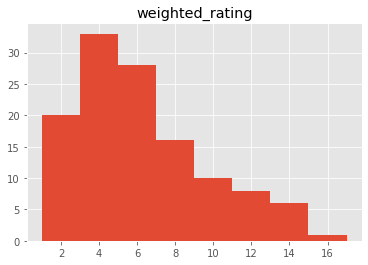

In [74]:
cdf.hist("weighted_rating", bins=range(1, 18, 2))

## **Hypothesis Testing**

Now that we have a better grasp on what the each professor-course looks like, lets see if we can make some discoveries about professor-course ratings based on the course grades: given the positive trend between grades and pair rating, can we reasonably presume a linear correlation between the two? We can explore this question through hypothesis testing. 

Our null and alternative hypotheses to the following: <br>

> $ H_{null} = 0 $ <br>
> $ H_{a} \neq 0 $ <br>

We will also use 0.05 as our level of significance.


To make the linear model, we will be using the [orinary least squares](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) from the statsmodel API. The package also allows us to inspect the summary statistics to see the significance of our model. 

In [75]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [76]:
model = smf.ols(formula="rating ~ average_gpa", data=cdf)
results = model.fit()

In [77]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     9.015
Date:                Wed, 14 Dec 2022   Prob (F-statistic):            0.00315
Time:                        21:27:31   Log-Likelihood:                -214.70
No. Observations:                 149   AIC:                             433.4
Df Residuals:                     147   BIC:                             439.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.4065      0.743      1.893      

From this summary table of the model, we observe that $ P > |t|$ for the average_gpa coefficient (0.03) is less than our significance level. This indicates that our model has a high statistical significance, which supports our suspicion that there is a linear relationship.

## **Language Processing**

Now that we've establish numerical relationships in our data, let's have a look at the written reviews posted by students. We see in the reviews dataframe that, for each written review, there is a numerical rating attached to it. FINISH.  

In [142]:
import nltk 
import string

from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer


In [91]:
nltk.download()


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [120]:
STOP_WORDS = set(stopwords.words("english"))
STEMMER = PorterStemmer()
LEMMER = nltk.WordNetLemmatizer()
rev_df = reviews[["review", "rating"]].copy()

In order to fit a NLP model onto the data we need to do a bunch of preprocessing, meaning we will need to format the text such that the algorithm we use can process the values easily. To do this, we will breakdown the text in the following fashion: 
1. Convert each word to lower case
2. Remove punctuation
3. Remove stop words
4. Tokenize
5. Execute stemming
6. Lemmatize 

In [128]:
def process_text(text: str):
    
    #make lower case and remove punctuation 
    text = "".join([x for x in text if x not in string.punctuation]).lower()

    #split words into individual strings then remove stop words
    text = [x for x in nltk.word_tokenize(text) if x not in STOP_WORDS]
    
    #retrieve word stems and lemmatize 
    text = [STEMMER.stem(x) for x in text]
    text = [LEMMER.lemmatize(x) for x in text]
    
    return text

In [129]:
test = "Easy class but awful professor. He is frequently absent to nonexistent on the student forum Piazza, and many questions are left unanswered or answered only affer they aren’t relevant anymore (i.e. exam/project questions after the deadline). A couple examples:\r\n\r\n1"

In [132]:
reviews["processed"] = reviews["review"].apply(process_text)
reviews["processed"].iloc[1]

['easi',
 'class',
 'aw',
 'professor',
 'frequent',
 'absent',
 'nonexist',
 'student',
 'forum',
 'piazza',
 'mani',
 'question',
 'left',
 'unansw',
 'answer',
 'affer',
 '’',
 'relev',
 'anymor',
 'ie',
 'examproject',
 'question',
 'deadlin',
 'coupl',
 'exampl',
 '1',
 'midterm',
 'learn',
 'stuff',
 'week',
 'exam',
 'porter',
 'confirm',
 'exam',
 'materi',
 'may',
 'includ',
 'taught',
 'lectur',
 'week',
 'neglect',
 'upload',
 'slide',
 'materi',
 'mani',
 'student',
 'ask',
 'forum',
 'slide',
 'frequent',
 '13',
 'hour',
 'exam',
 '9',
 'hour',
 '5',
 '2',
 'hour',
 'exam',
 'thread',
 'one',
 'hour',
 'exam',
 'professor',
 'final',
 'respond',
 'say',
 '“',
 'sorri',
 'miss',
 'slide',
 '”',
 'still',
 'neglect',
 'upload',
 '2',
 'tuesday',
 'week',
 'thanksgiv',
 'break',
 'porter',
 'assign',
 'u',
 'anoth',
 'lab',
 'due',
 'follow',
 'monday',
 '2',
 'day',
 'break',
 'student',
 'post',
 'forum',
 'ask',
 'extens',
 'lab',
 'due',
 'date',
 'mani',
 'peopl',
 'trav

We have now broken each review into a string that simplifies the language into components. 

In [143]:
X = reviews["processed"].copy()
Y = reviews["rating"].copy()

In [144]:
X = CountVectorizer(max_features=1000).fit_transform(X).toarray()

AttributeError: 'list' object has no attribute 'lower'

In [140]:
clf = RandomForestClassifier(max_depth=10)
clf.fit(X, Y)

ValueError: setting an array element with a sequence.

In [ ]:
stop_words = set(stopwords.words('english'))
textt = " ".join(review for review in reviews.review)
wc = WordCloud(stopwords=stop_words).generate(textt)

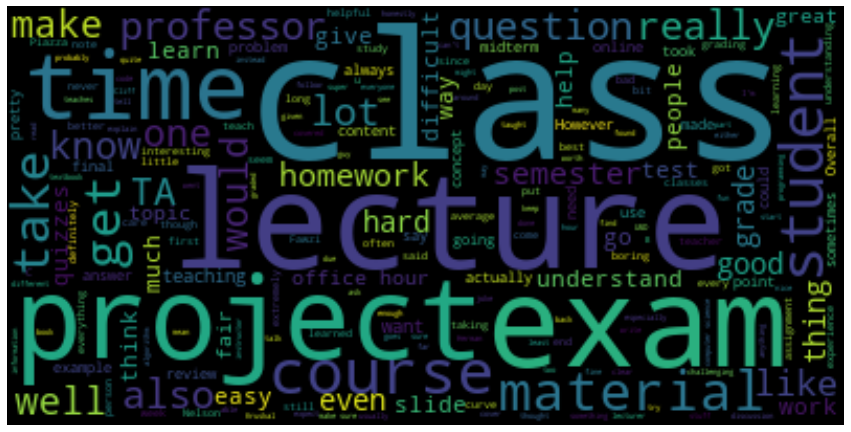

In [ ]:
fig = plt.figure(figsize =(15, 10))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()